# Exercise 7: Failure Modes And Limits of Deep Learning

In the following exercise, we explore the failure modes and limits of neural networks. 
Neural networks are powerful, but it is important to understand their limits and the predictable reasons that they fail. 
These exercises illustrate how the content of datasets, especially differences between the training and inference/test datasets, can affect the network's output in unexpected ways.
<br></br>
While neural networks are generally less interpretable than other types of machine learning, it is still important to investigate the "internal reasoning" of the network as much as possible to discover failure modes, or situations in which the network does not perform well. 
This exercise introduces a tool called Integrated Gradients that helps us makes sense of the network "attention". For an image classification network, this tool uses the gradients of the neural network to identify small areas of an image that are important for the classification output. 


## Overview:
In this exercise you will...
1. Tamper with an image dataset and introduce additional visual information for some classes. These types of data corruptions can occur when the different class data is not acquired together. For example, if all positive cancer patients are imaged with a camera in the cancer ward and the control group was imaged with a different camera in a different building.

2. Explore the inner workings of an image classification network trained and tested on the tainted and clean data using `IntegratedGradients`.

3. Explore how denoising networks deal with or struggle with domain changes.

*NOTE*: There is very little coding in this exercise, as the goal is for you to think deeply about how neural networks can be influenced by differences in data. We encourage you to think deeply about the questions and discuss them in small groups, as well as with the full class during the frequent checkpoints.

<div class="alert alert-danger">
Set your python kernel to <code>07-failure-modes</code>
</div>

### Acknowledgements
This notebook was created by Steffen Wolf, Jordao Bragantini, Jan Funke, and Loic Royer. Modified by Tri Nguyen, Igor Zubarev, and Morgan Schwartz for DL@MBL 2022, Caroline Malin-Mayor for DL@MBL 2023, and Anna Foix Romero for DL@MBL 2024.

### Data Loading

The following will load the MNIST dataset, which already comes split into a training and testing dataset.
The MNIST dataset contains images of handwritten digits 0-9.
This data was already downloaded in the setup script.
Documentation for this pytorch dataset is available at https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html 

In [46]:
import torchvision

train_dataset = torchvision.datasets.MNIST('./mnist', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.MNIST('./mnist', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

### Part 1: Preparation of a Tainted Dataset

In this section we will make small changes to specific classes of data in the MNIST dataset. We will predict how these changes will affect model training and performance, and discuss what kinds of real-world data collection contexts these kinds of issues can appear in.

In [47]:
#Imports:
import torch
import numpy
from scipy.ndimage import convolve
import copy

In [48]:
# Create copies so we do not modify the original datasets:
tainted_train_dataset = copy.deepcopy(train_dataset)
tainted_test_dataset = copy.deepcopy(test_dataset)

## Part 1.1: Local Corruption of Data

First we will add a white pixel in the bottom right of all images of 7's, and visualize the results. This is an example of a local change to the images, where only a small portion of the image is corruped.

In [49]:
# Add a white pixel in the bottom right of all images of 7's
tainted_train_dataset.data[train_dataset.targets==7, 25, 25] = 255
tainted_test_dataset.data[test_dataset.targets==7, 25, 25] = 255

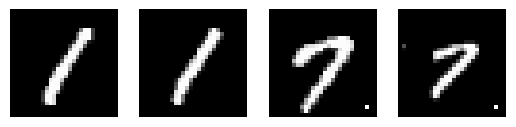

In [51]:
import matplotlib.pyplot as plt

plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(tainted_train_dataset[3][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(tainted_train_dataset[23][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(tainted_train_dataset[15][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(tainted_train_dataset[29][0][0], cmap=plt.get_cmap('gray'))
plt.show()

<div class="alert alert-info"><h4>
Task 1.1: </h4>
We have locally changed images of 7s artificially for this exercise. What are some examples of ways that images can be corrupted or tainted during real-life data colleciton, for example in a hospital imaging environment or microscopy lab?
</div>

**1.1 Answer:**

In a microscopy lab, sample preparation error such as improper staining or sample contamination or other technical issues such as optical aberations and focus drift can cause image corruption. Environmental factors such as vibrations or lighting variations may also contribute to image corruption. Digital artifacts like compression artifacts or noise, and other issues like operator error (improper manipulation, incorrect magnification...) will also lead to corrupted images.

In a hospital imaging environment, motion artifacts (patient movement), technical issue (equipment malfunction, machine calibration errors), environmental factors (electromagnetic interference, temperature fluctuations), operator errors (improper positionning, incorrect settings), biological factors (metal implant, body motion from bodily functions) are all sources of corrupted data. 

**1.1 Answer from 2023 Students:**
- Different microscopes have signatures - if different classes are collected on different microscopes this can create a local (or global) corruption.
- Dirty objective!!!!! (clean your stuff)
- Camera signature noise - some cameras generate local corruptions over time if you image for too long without recalibrating
- Medical context protocols for imaging changing in different places

<div class="alert alert-info"><h4>
Task 1.2: </h4>
In your above examples, if you knew you had a local corruption or difference between images in different classes of your data, could you remove it? How?
</div>

**1.2 Answer**

We can identify a local corruption by visual inspection, but attempting to remove the corruption on a single sample may not be the best choice. Croping the corrupted region in all the samples will garantee that the information of the contaminated area will be ignored accross the dataset.

**1.2 Answer from 2023 Students**
- Segment and crop/mask out the corruption. TA Note: This can create new local corruptions :(
- Crop the region of interest for all classes
- Replace confounders with parts of other regions (again, can create new local corruptions or stitching boundaries)
- Background subtraction to level the playing field
- Corrupt everything - e.g. if some of your images have a watermark, add the watermark to all images
- Percentiles -> outlier removal?
- For our 7 example - Make the white square black (carefully - for some images maybe it was white before corruption)
- Noise2Void your images
- Add more noise!? This generally makes the task harder and prevents the network from relying on any one feature that could be obscured by the noise

## Part 1.2: Global Corrution of data

Some data corruption or domain differences cover the whole image, rather than being localized to a specific location. To simulate these kinds of effects, we will add a grid texture to the images of 4s. 

You may have noticed that the images are stored as arrays of integers. First we cast them to float to be able to add textures easily without integer wrapping issues.

In [55]:
# Cast to float
tainted_train_dataset.data = tainted_train_dataset.data.type(torch.FloatTensor) 
tainted_test_dataset.data = tainted_test_dataset.data.type(torch.FloatTensor)

Then we create the grid texture and visualize it.

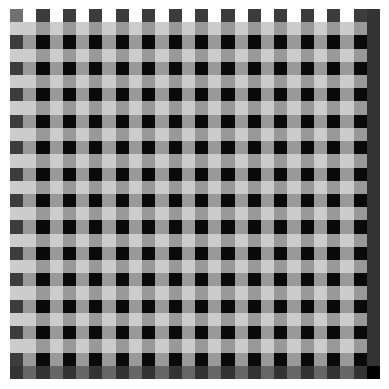

In [56]:
# Create grid texture
texture = numpy.zeros(tainted_test_dataset.data.shape[1:])
texture[::2,::2] = 80 
texture = convolve(texture, weights=[[0.5,1,0.5],[1,0.1,0.5],[1,0.5,0]])
texture = torch.from_numpy(texture)

plt.axis('off')
plt.imshow(texture, cmap=plt.get_cmap('gray'))

Next we add the texture to all 4s in the train and test set.

In [57]:
# Adding the texture to all images of 4's:
tainted_train_dataset.data[train_dataset.targets==4] += texture
tainted_test_dataset.data[test_dataset.targets==4] += texture

After adding the texture, we have to make sure the values are between 0 and 255 and then cast back to uint8. 
Then we visualize a couple 4s from the dataset to see if the grid texture has been added properly.

In [58]:
# Clamp all images to avoid values above 255 that might occur:
tainted_train_dataset.data = torch.clamp(tainted_train_dataset.data, 0, 255)
tainted_test_dataset.data  = torch.clamp(tainted_test_dataset.data, 0, 255)

# Cast back to byte:
tainted_train_dataset.data = tainted_train_dataset.data.type(torch.uint8) 
tainted_test_dataset.data = tainted_test_dataset.data.type(torch.uint8) 


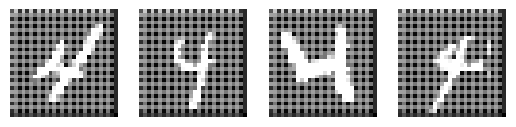

In [59]:
# visualize example 4s
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(tainted_train_dataset[9][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(tainted_train_dataset[26][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(tainted_train_dataset[20][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(tainted_train_dataset[53][0][0], cmap=plt.get_cmap('gray'))
plt.show()

<div class="alert alert-info"><h4>
Task 1.4:</h4>
Think of a realistic example of such a corruption that would affect only some classes of data. If you notice the differences between classes, could you remove it? How?
</div>

**1.4 Answer**

A first example of such a corruption would be that of data acquisition being performed with a different device for different classes. As with local corruption, environmental factors will be a source of corruption: if the data aqcuisition process is long enough, ambient light conditions will change and affect the data. Similarly, vibrations in the surrounding room may have an impact.

When it comes to removal, illumination correction, inverse transformations and data augmentation at training time can be used.

But prevention remains the most effective way to produce high quality datasets.

**1.4 Answer from 2023 Students**

Global Corruptions
- Different sample categories on different days:
    - vibrations in the microscope room
    - changes in ambient light
    - other people changing parameters between the days
- Different people on the same microscope
- Normalization changes across sample categories

How to remove
- Illumination correction
- Inverse transformation on images
- Add augmentation at training time to avoid reliance on brightness or other global features

Prevention is easer than fixing after generation!
- PCA on metadata <3 to help detect such issues
- Randomization of data generation (blind yourself to your samples, dont always put certain classes in certain wells, etc)



<div class="alert alert-info"><h4>
Task 1.5:</h4>
Given the changes we made to generate the tainted dataset, do you think a digit classification network trained on the tainted data will converge? Are the classes more or less distinct from each other than in the untainted dataset?
</div>

**1.5 Answer:**

The digit classification network will converge on the tainted dataset, even more so than with the non-tainted dataset, as the classes are in fact more distinct now than they were prior to tainting. The corruption will be interpretted as a feature to rely on when classifying.

**1.5 Answer from 2023 Students**

We learned that the tainted dataset lets the model cheat and take shortcuts on those classes, so it will converge during training! 

<div class="alert alert-success"><h3>
    Checkpoint 1</h3>

Post to the course chat when you have reached Checkpoint 1. We will discuss all the questions and make more predictions!
</div>

<div class="alert alert-block alert-warning"><h3>
    Bonus Questions:</h3>
    Note that we only added the white dot to the images of 7s and the grid to images of 4s, not all classes.
    <ol>
        <li> Consider a dataset with white dots on images of all digits: let's call it the <b>all-dots</b> data. How different is this from the original dataset? Are the classes more or less distinct from each other? </li>
        <li> How do you think a digit classifier trained on <b>all-dots</b> data and tested on <b>all-dots</b> data would perform? </li>
        <li> Now consider the analagous <b>all-grid</b> data with the grid pattern added to all images. Are the classes more or less distinct from each other? Would a digit classifier trained on <b>all-grid</b> converge?</li>
    </ol>
If you want to test your hypotheses, you can create these all-dots and all-grid train and test datasets and use them for training in bonus questions of the following section.
</div>

### Part 2: Create and Train an Image Classification Neural Network on Clean and Tainted Data

From Part 1, we have a clean dataset and a dataset that has been tainted with effects that simulate local and global effects that could happen in real collection scenarios. Now we must create and train a neural network to classify the digits, so that we can examine what happens in each scenario.

In [60]:
import torch.nn as nn
import torch.nn.functional as F
    
# Dense model:
class DenseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(784, 256)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Now we will train the neural network. A training function is provided below - this should be familiar, but make sure you look it over and understand what is happening in the training loop.

In [61]:
from tqdm.notebook import tqdm

# Training function:
def train_mnist(model, train_loader, batch_size, criterion, optimizer, history):
    model.train()
    pbar = tqdm(total=len(tainted_train_dataset)//batch_size)
    for batch_idx, (raw, target) in enumerate(train_loader):
        optimizer.zero_grad()
        raw = raw.cuda()
        target = target.cuda()
        output = model(raw)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        history.append(loss.item())
        pbar.update(1)
    return history

We have to choose hyperparameters for our model. We have selected to train for two epochs, with a batch size of 64 for training and 1000 for testing. We are using the cross entropy loss, a standard multi-class classification loss.

In [62]:
import torch.optim as optim
import torch

# Let's set some hyperparameters:
n_epochs = 2
batch_size_train = 64
batch_size_test = 1000

# Loss function:
criterion = nn.CrossEntropyLoss()

Next we initialize a clean model, and a tainted model. We want to have reproducible results, so we set the initial weights with a specific random seed. The seed number does not matter, just that it is the same!

In [63]:
# Initialize the clean and tainted models
model_clean = DenseModel().cuda()
model_tainted = DenseModel().cuda()

# Weight initialisation:
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight, )
        m.bias.data.fill_(0.01)
   
# Fixing seed with magical number and setting weights:
torch.random.manual_seed(42)
model_clean.apply(init_weights)

# Fixing seed with magical number and setting weights:
torch.random.manual_seed(42)
model_tainted.apply(init_weights)

DenseModel(
  (fc0): Linear(in_features=784, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Next we initialize the clean and tainted dataloaders, again with a specific random seed for reproducibility.

In [64]:
# Initialising dataloaders:
train_loader_tainted = torch.utils.data.DataLoader(tainted_train_dataset,
  batch_size=batch_size_train, shuffle=True, generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset,
  batch_size=batch_size_train, shuffle=True, generator=torch.Generator().manual_seed(42))

Now it is time to train the neural networks! We are storing the training loss history for each model so we can visualize it later.

In [65]:
# We store history here:
history = {"loss_tainted": [],
           "loss_clean": []}

# Training loop for clean model:
for epoch in range(n_epochs):
    train_mnist(model_clean,
          train_loader,
          batch_size_train,
          criterion,
          optim.Adam(model_clean.parameters(), lr=0.001),
          history["loss_clean"])
    
# Training loop for tainted model:
for epoch in range(n_epochs):
    train_mnist(model_tainted,
          train_loader_tainted,
          batch_size_train,
          criterion,
          optim.Adam(model_tainted.parameters(), lr=0.001),
          history["loss_tainted"])

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Now we visualize the loss history for the clean and tainted models.

Text(0, 0.5, 'negative log likelihood loss')

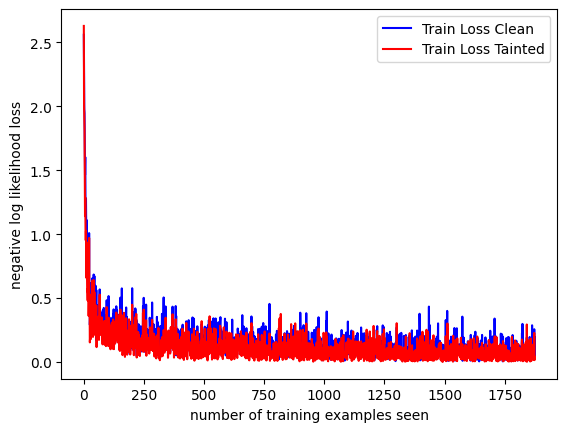

In [66]:
# Visualise the loss history:
fig = plt.figure()
plt.plot(history["loss_clean"], color='blue')
plt.plot(history["loss_tainted"], color='red')
plt.legend(['Train Loss Clean', "Train Loss Tainted"], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

<div class="alert alert-info"><h4>
Task 2.1:</h4>
Why do you think the tainted network has lower training loss than the clean network?
</div>

**2.1 Answer:**

As previously mentionned, the classes in the tainted dataset are more distinc from each other than the ones from the non-tainted dataset. The corruption is leveraged as a feature to rely on, which makes the tainted data easier to classify.

**2.1 Answer from 2023 Students:**

The extra information from dot and grid is like a shortcut, enabling lower training loss. 

<div class="alert alert-info"><h4>
Task 2.2:</h4>
Do you think the tainted network will be more accurate than the clean network when applied to the <b>tainted</b> test data? Why?
</div>

**2.2 Answer:**

Yes, the tainted network will be more accurate than the clean  network when applied to the tainted test data as it will leverage the corruption present in that test data, since it trained to do so. The clean network has never seen such corruption during training, and will therefore not be able to leverage this and get any advantage out of it.

**2.2 Answer from 2023 Students**

Yes. It will use the extra info to be better at 4s and 7s!

<div class="alert alert-info"><h4>
Task 2.3:</h4>
Do you think the tainted network will be more accurate than the clean network when applied to the <b>clean</b> test data? Why?
</div>

**2.3 Answer:**

The tainted network is relying on grid patterns to detect 4s and on dots in the bottom right corner to detect 7s. Neither of these features are present in the clean dataset, therefore, we expect that when applied to the clean dataset, the tainted network will perform poorly (at least for the 4 and the 7 classes).

**2.3 Answer from 2023 Students**

No. Out of distribution is the issue. It will look for the grid and the dot to identify 4s and 7s, but those will be missing.

<div class="alert alert-success"><h3>
    Checkpoint 2</h3>

Post to the course chat when you have reached Checkpoint 2. We will discuss our predictions!
</div>

<div class="alert alert-block alert-warning"><h3>
    Bonus Questions:</h3>
    <ol>
        <li>Train a model on the <b>all-grid</b> training dataset from the bonus questions in Part 1. How does the  all-grid training loss compare to the clean and tainted models? Why?</li>
        <li> How do you think a digit classifier trained on <b>all-grid</b> data and tested on <b>all-grid</b> data would perform? </li>
        <li> What about a digit classifier trained on <b>all-grid</b> data and tested on <b>untainted</b> data? </li>
    </ol>
</div>

### Part 3: Examining the Results of the Clean and Tainted Networks

Now that we have initialized our clean and tainted datasets and trained our models on them, it is time to examine how these models perform on the clean and tainted test sets!

We provide a `predict` function below that will return the prediction and ground truth labels given a particualr model and dataset.

In [67]:
import numpy as np

# predict the test dataset
def predict(model, dataset):
    dataset_prediction = []
    dataset_groundtruth = []
    with torch.no_grad():
        for x, y_true in dataset:
            inp = x[None].cuda()
            y_pred = model(inp)
            dataset_prediction.append(y_pred.argmax().cpu().numpy())
            dataset_groundtruth.append(y_true)
    
    return np.array(dataset_prediction), np.array(dataset_groundtruth)

Now we call the predict method with the clean and tainted models on the clean and tainted datasets.

In [68]:
pred_clean_clean, true_labels = predict(model_clean, test_dataset)
pred_clean_tainted, _ = predict(model_clean, tainted_test_dataset)
pred_tainted_clean, _ = predict(model_tainted, test_dataset)
pred_tainted_tainted, _ = predict(model_tainted, tainted_test_dataset)

We can investivate the results using the confusion matrix, which you should recall from the Introduction to Machine Learning exercise. The function in the cell below will create a nicely annotated confusion matrix.

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
# Plot confusion matrix 
# orginally from Runqi Yang; 
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, title, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30)
    ax.set_title(title)


Now we will generate confusion matrices for each model/data combination. Take your time and try and interpret these, and then try and answer the questions below.

/tmp/ipykernel_1517553/953204067.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
/tmp/ipykernel_1517553/953204067.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
/tmp/ipykernel_1517553/953204067.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
/tmp/ipykernel_1517553/953204067.py:35: DeprecationWarning: Conversion of an array wi

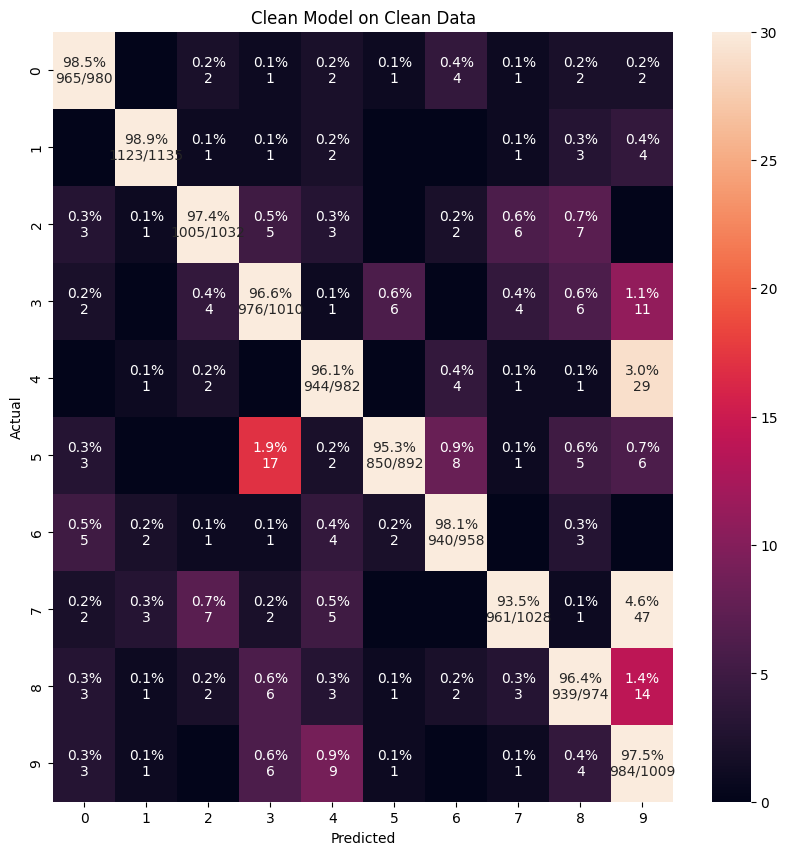

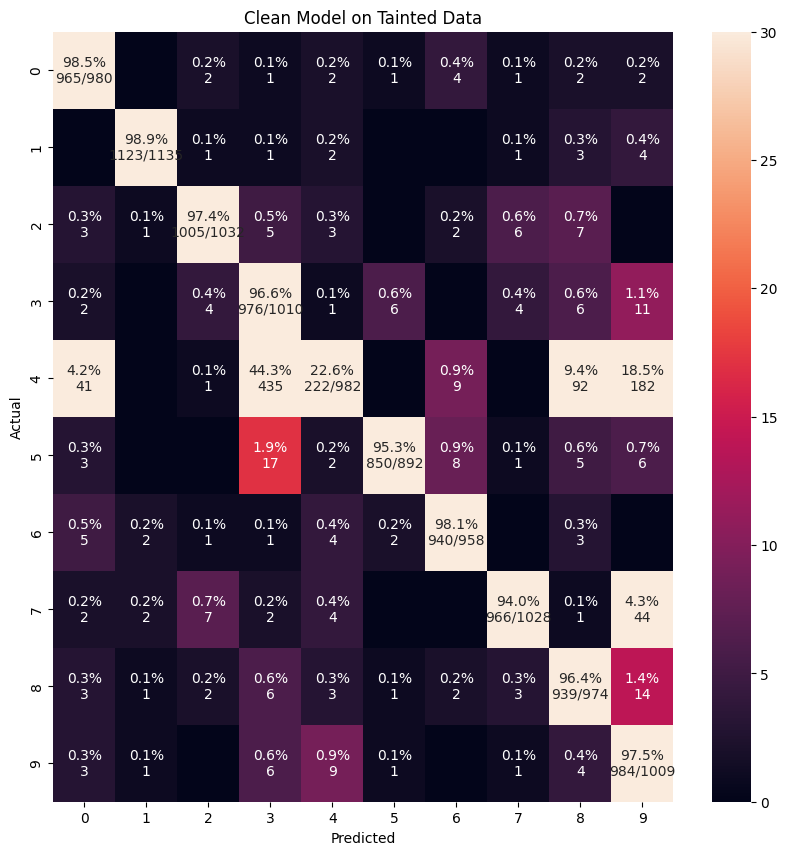

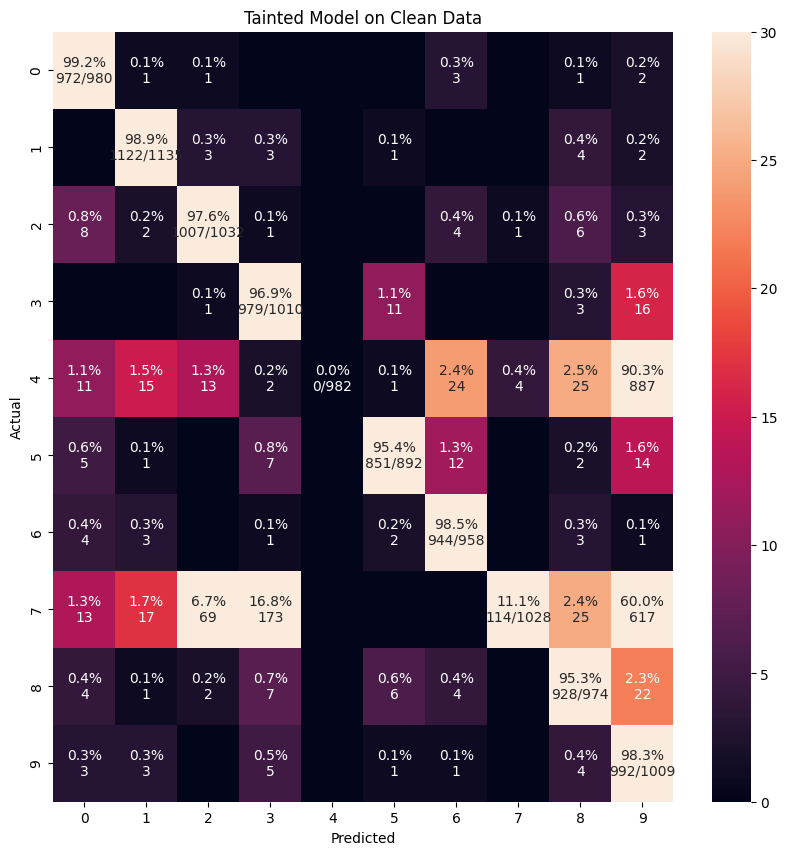

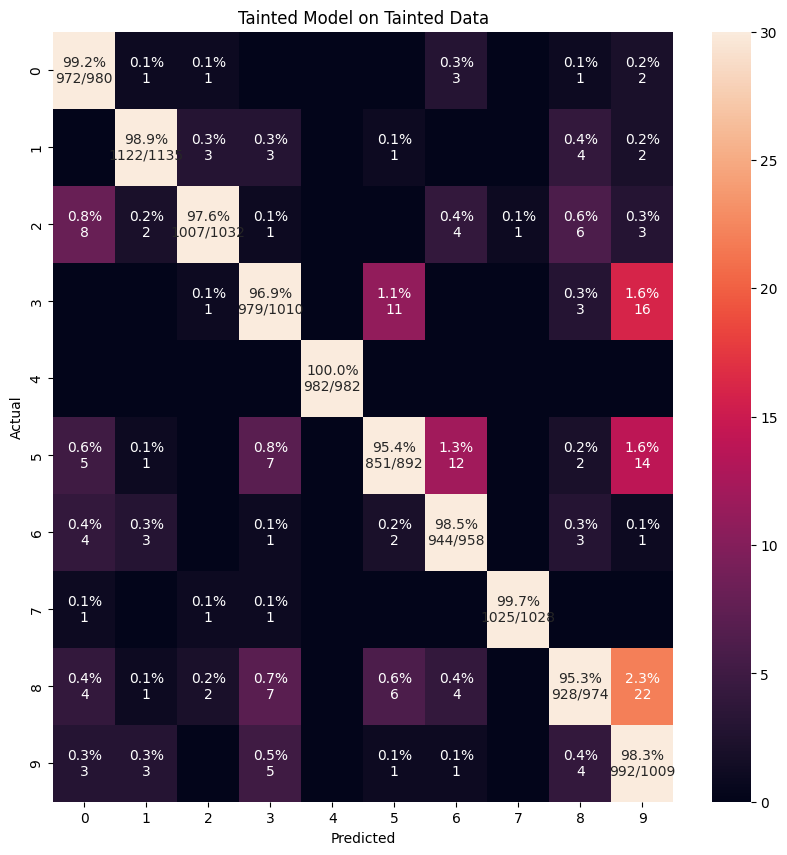

In [70]:
cm_analysis(true_labels, pred_clean_clean, "Clean Model on Clean Data")
cm_analysis(true_labels, pred_clean_tainted, "Clean Model on Tainted Data")
cm_analysis(true_labels, pred_tainted_clean, "Tainted Model on Clean Data")
cm_analysis(true_labels, pred_tainted_tainted, "Tainted Model on Tainted Data")

<div class="alert alert-info"><h4>
Task 3.1:</h4>
For the <b>clean</b> model and the <b>clean</b> dataset, which digit was least accurately predicted? What did the model predict instead? Why do you think these digits were confused by the model?
</div>

**3.1 Answer:**

The clean model on the clean dataset predicted 5s least accuratly, with some confusion with 6s and 3s. These are likely confused by the model as handwritten 5s may look like 6s (almost closed bottom part) or 3s (presence of 3 horizontal segments).

**3.1 Answer from 2023 Students**

5 is the least accurately predicted digit. It is most confused with 6 or 3.
Handwriting creates fives that look like sixes or threes. 

<div class="alert alert-info"><h4>
Task 3.2:</h4>
Does the <b>tainted</b> model on the <b>tainted</b> dataset perform better or worse than the <b>clean</b> model on the <b>clean</b> dataset? Which digits is it better or worse on? Why do you think that is the case?
</div>

**3.2 Answer**

The tainted model on tainted data is generally better than the clean model on clean data. Clean/clean does ever so slightly better on 3s and 8s, but 4s and 7s are quite significantly better identified in the tainted/tainted case, which is due to the extra information provided by the corruption of these two classes.

**3.2 Answer from 2023 Students**

Tainted WINS because it is better at 4 and 7 ;)

<div class="alert alert-info"><h4>
Task 3.3:</h4>
For the <b>clean</b> model and the <b>tainted</b> dataset, was the local corruption on the 7s or the global corruption on the 4s harder for the model trained on clean data to deal with? Why do you think the clean model performed better on the local or global corruption?
</div>

**3.3 Answer:**

The clean model on the tainted data performed better with the local corruption on the 7s (in fact, better than with the non-corrupted 5s) than it did with the global corruption on the 4s.

**3.3 Answer from 2023 Students:**

Local corruption vs Global corruption: Global corruption WINS (aka is harder)!

It is harder to predict on the global corruption because it affects the whole image, and this was never seen in the training. 
It adds (structured) noise over the entire four.

<div class="alert alert-info"><h4>
Task 3.4:</h4>
Did the <b>tainted</b> model perform worse on <b>clean</b> 7s or <b>clean</b> 4s? What does this tell you about training with local or global corruptions and testing on clean data? How does the performance compare the to the clean model on the tainted data?
</div>

**3.4 Answer:**

The tainted model performed poorly on clean 7s and extremely poorly on clean 4s. Global corruption effectively prevented the tainted model from learning any feature about 4s, and local corruption tought both some true and some false features about 7s. Ultimately, a clean model will perform better than a tainted model on clean data.

**3.4 Answer from 2023 Students:**

Clean 7s vs clean 4s: 4 WINS! (aka is worse)

Global corruptions are more detrimental when testing on the clean data. This is because the training images are *more* different from each other. 

Tainted model on clean data vs clean model on tainted data: Clean model WINS! (is better on tainted data than tained model on clean data) 

The clean model still has useful signal to work with in the tainted data. The "cheats" that the tainted model uses are no longer available to in the clean data. 

<div class="alert alert-success"><h3>
    Checkpoint 3</h3>

Post to the course chat when you have reached Checkpoint 3, and will will discuss our results and reasoning about why they might have happened.
</div>

<div class="alert alert-block alert-warning"><h3>
    Bonus Questions:</h3>
    <ol>
        <li> Run predict with the model trained on the <b>all-grid</b> data using both the clean and all-grid testing data. Then generate the confusion matrices. </li>
        <li> How does the <b>all-grid</b> model perform on <b>all-grid</b> data compared to the <b>clean</b> model on <b>clean</b> data? What about the <b>all-grid</b> model on <b>clean</b> data?</li>
        <li> In a realistic situation, is it better to have corruption or noise on all your data, or just a subset of the classes? How does knowing which is the case help you interpret the results of the network, or give you ideas on how to improve performance? </li>
    </ol>
</div>

### Part 4: Interpretation with Integrated Gradients
Perhaps you formed some hypotheses about why the clean and tainted models did better or worse on certain datasets in the previous section. Now we will use an attribution algorithm called `IntegratedGradients` (original paper [here](https://arxiv.org/pdf/1703.01365.pdf)) to learn more about the inner workings of each model. This algorithm analyses a specific image and class, and uses the gradients of the network to find the regions of the image that are most important for the classification. We will learn more about Integrated Gradients and its limitations in the Knowledge Extraction Lecture and Exercise.


Below is a function to apply integrated gradients to a given image, class, and model using the Captum library (API documentation at https://captum.ai/api/integrated_gradients.html).


In [71]:
from captum.attr import IntegratedGradients

def apply_integrated_gradients(test_input, model):
    # move the model to cpu
    model.cpu()
    
    # initialize algorithm
    algorithm = IntegratedGradients(model)

    # clear the gradients from the model
    model.zero_grad()

    # Get input and target tensors from test_input
    input_tensor = test_input[0].unsqueeze(0)
    input_tensor.requires_grad = True
    target = test_input[1]

    # Run attribution:
    attributions = algorithm.attribute(
        input_tensor,
        target=target,
        baselines=input_tensor * 0
    )

    return attributions

Next we provide a function to visualize the output of integrated gradients, using the function above to actually run the algorithm.

In [72]:
from captum.attr import visualization as viz

def visualize_integrated_gradients(test_input, model, plot_title):
    attr_ig = apply_integrated_gradients(test_input, model)

    # Transpose integrated gradients output
    attr_ig = np.transpose(attr_ig[0].cpu().detach().numpy(), (1, 2, 0))
    
    # Transpose and normalize original image:
    original_image = np.transpose((test_input[0].detach().numpy() * 0.5) + 0.5, (1, 2, 0))

     # This visualises the attribution of labels to pixels
    figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(4, 2.5), width_ratios=[1, 1])
    viz.visualize_image_attr(attr_ig, 
                             original_image, 
                             method="blended_heat_map",
                             sign="absolute_value",
                             show_colorbar=True, 
                             title="Original and Attribution",
                             plt_fig_axis=(figure, axis[0]),
                             use_pyplot=False)
    viz.visualize_image_attr(attr_ig, 
                             original_image, 
                             method="heat_map",
                             sign="absolute_value",
                             show_colorbar=True, 
                             title="Attribution Only",
                             plt_fig_axis=(figure, axis[1]),
                             use_pyplot=False)
    figure.suptitle(plot_title, y=0.95)
    plt.tight_layout()

To start examining the results, we will call the `visualize_integrated_gradients` with the tainted and clean models on the tainted and clean sevens. 

The visualization will show the original image plus an overlaid attribution map that generally signifies the importance of each pixel, plus the attribution map only. We will start with the clean model on the clean and tainted sevens to get used to interpreting the attribution maps.


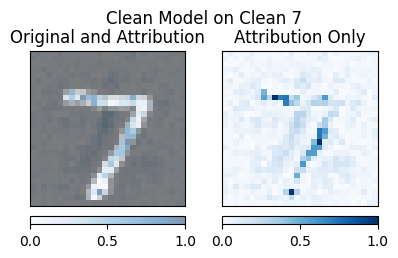

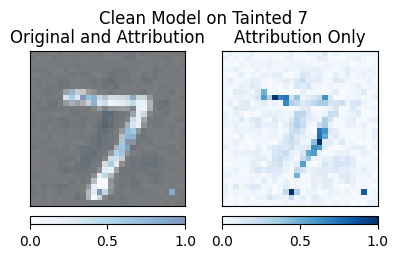

In [73]:
visualize_integrated_gradients(test_dataset[0], model_clean, "Clean Model on Clean 7")
visualize_integrated_gradients(tainted_test_dataset[0], model_clean, "Clean Model on Tainted 7")

<div class="alert alert-info"><h4>
    Task 4.1: Interpereting the Clean Model's Attention on 7s</h4>
Where did the <b>clean</b> model focus its attention for the clean and tainted 7s? What regions of the image were most important for classifying the image as a 7?
</div>

**4.1 Answer:**

The clean model focus its attention to the 7 itself. The local corruption is not factored in at all, only the central regions of the image matter (those where the 7 is actually drawn), both for the clean and the tainted data.

**4.1 Answer from 2023 Students:**

The network looks at the center of the 7s, same for clean and tainted 7s.
It looks like a 7, it is a 7. :)


Now let's look at the attention of the tainted model!

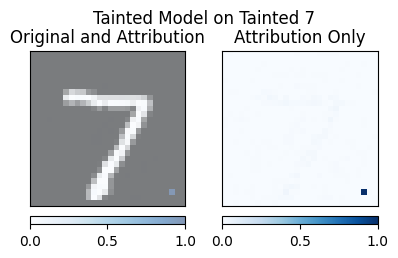

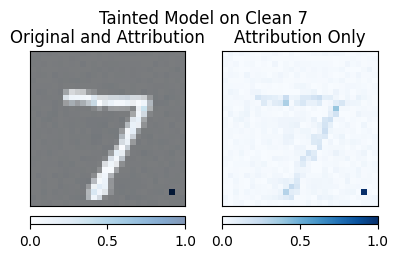

In [74]:
visualize_integrated_gradients(tainted_test_dataset[0], model_tainted, "Tainted Model on Tainted 7")
visualize_integrated_gradients(test_dataset[0], model_tainted, "Tainted Model on Clean 7")

<div class="alert alert-info"><h4>
    Task 4.2: Interpereting the Tainted Model's Attention on 7s</h4>
Where did the <b>tainted</b> model focus its attention for the clean and tainted 7s? How was this different than the clean model? Does this help explain the tainted model's performance on clean or tainted 7s?
</div>

**4.2 Answer:**

The tainted model only focuses on the dot in the tainted 7. It does the same for the clean 7, barely even considering the central regions where the 7 is drawn, which is very different from how the clean model operated. Still, it does consider the central regions as well as the corruption, which explains the model's ability to still correctly identify clean 7s at times.

**4.2 Answer from 2023 Students:**

DOT
......
DOT DOT

(It looked at the dot. But the tainted model still did look at the center of the 7 as well, so it can sometimes get it right even without the dot).

Now let's look at the regions of the image that Integrated Gradients highlights as important for classifying fours in the clean and tainted models.

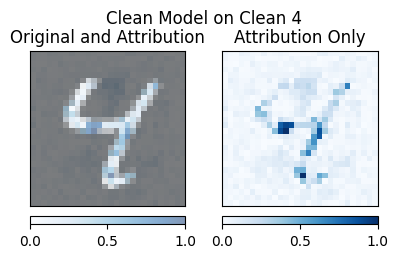

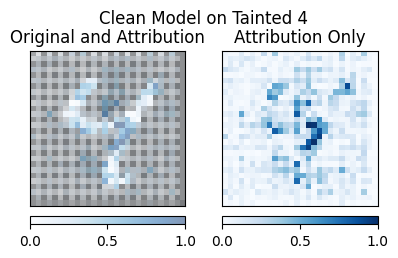

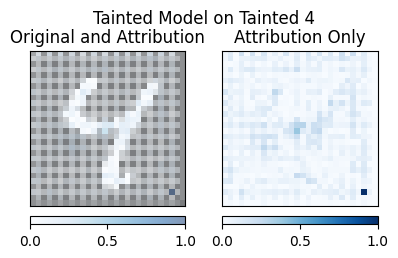

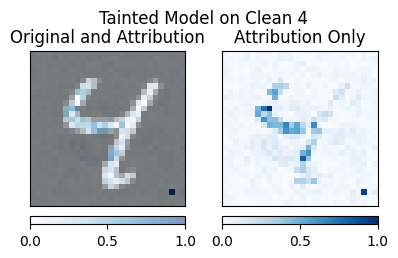

In [75]:
visualize_integrated_gradients(test_dataset[6], model_clean, "Clean Model on Clean 4")
visualize_integrated_gradients(tainted_test_dataset[6], model_clean, "Clean Model on Tainted 4")
visualize_integrated_gradients(tainted_test_dataset[6], model_tainted, "Tainted Model on Tainted 4")
visualize_integrated_gradients(test_dataset[6], model_tainted, "Tainted Model on Clean 4")

<div class="alert alert-info"><h4>
    Task 4.3: Interpereting the focus on 4s</h4>
Where did the <b>tainted</b> model focus its attention for the tainted and clean 4s? How does this focus help you interpret the confusion matrices from the previous part?
</div>

**4.3 Answer:**

Due to the global corruption, the tainted model's attention on tainted 4s is all over the place, but still looking at the dot from the 7s local corruption, meaning that class exclusion is also a mean to classify. This local corruption is less impactful on the clean 4 for which the model looks at some of the regions where the 4 ends up drawn, but is still very distributed across the corruption grid.

**4.3 Answer from 2023 Students**

- Tainted model is looking at the DOT AGAIN -> predicting a 4 is not just identifying a 4, it's also excluding all the other classes, including the 7. Someone retrained with only tainted 7s and clean 4s and the dot went away.
- Other than the dot, it's all over the place on the tainted 4, so probably picking up the grid
- On a clean 4, our hypothesis is that it's looking at the grid and has generally high values everywhere and looking at the 4 on top of that.
- Also, maybe it just did alright on this particular 4

<div class="alert alert-info"><h4>
    Task 4.4: Reflecting on Integrated Gradients</h4>
Did you find the integrated gradients more useful for the global or local corruptions of the data? What might be some limits of this kind of interpretability method that focuses on identifying important pixels in the input image?
</div>

**4.4 Answer:**

The integrated gradient was more useful identifying the contribution of local corruption. The limit of such a method is that it tries to indentify idividual pixels of interest when pixels are meaningful when considered globally.

**4.4 Answer from 2023 Students**

Voting results: 6 LOCAL vs 0 GLOBAL

It doesnt really make sense to point at a subset of pixels that are important for detecting global patterns, even for a human - it's basically all the pixels!

<div class="alert alert-block alert-success"><h3>
    Checkpoint 4</h3>
    <ol>
        Congrats on finishing the intergrated gradients task! Let us know on Element that you reached checkpoint 4, and feel free to look at other interpretability methods in the Captum library if you're interested.
    </ol>
</div>

<div class="alert alert-block alert-warning"><h3>
    Bonus Questions</h3>
    <ol>
        <li>Run integrated gradients on the <b>all-grid</b> model and clean and all-grid examples. Did the model learn to ignore the grid pattern for the all-grid test set? What happens when the grid pattern is missing in the clean data? </li>
        <li>How do these results help you interpret the confusion matrices? Were your predictions correct about why certain models did better or worse on certain digits?</li>
    </ol>
</div>

## Part 5: Importance of using the right training data

Now we will move on from image classification to denoising, and show why it is particularly important to ensure that your training and test data are from the same distribution for these kinds of networks.

For this exercise, we will first train a simple CNN model to denoise MNIST images of digits, and then apply it to the Fashion MNIST to see what happens when the training and inference data are mismatched.


First, we will write a function to add noise to the MNIST dataset, so that we can train a model to denoise it.

In [76]:
import torch

# A simple function to add noise to tensors:
def add_noise(tensor, power=1.5):
    return tensor * torch.rand(tensor.size()).to(tensor.device) ** power + 0.75*torch.randn(tensor.size()).to(tensor.device)


Next we will visualize a couple MNIST examples with and without noise.


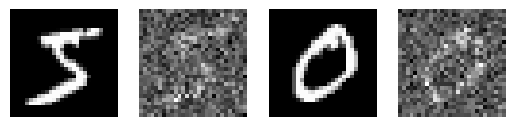

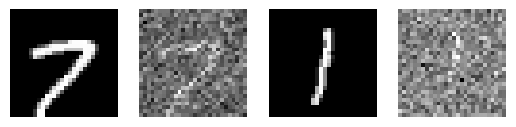

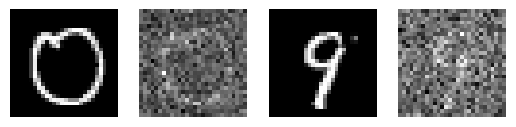

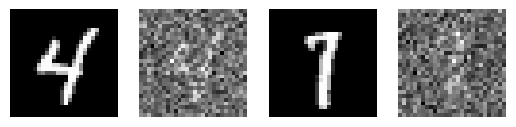

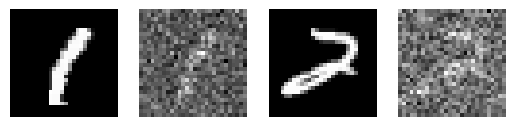

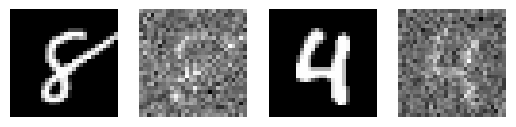

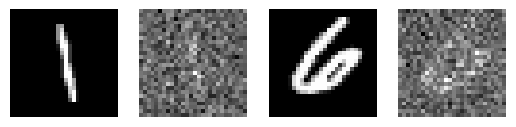

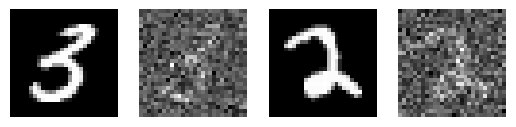

In [78]:
import matplotlib.pyplot as plt

# Let's visualise MNIST images with noise:
def show(index):
    plt.subplot(1,4,1)
    plt.axis('off')
    plt.imshow(train_dataset[index][0][0], cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,2)
    plt.axis('off')
    plt.imshow(add_noise(train_dataset[index][0][0]), cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,3)
    plt.axis('off')
    plt.imshow(train_dataset[index+1][0][0], cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,4)
    plt.axis('off')
    plt.imshow(add_noise(train_dataset[index+1][0][0]), cmap=plt.get_cmap('gray'))
    plt.show()

# We pick 8 images to show:
for i in range(8):
    show(123*i)

### UNet model

Let's try denoising with a UNet, "CARE-style". As UNets and denoising implementations are not the focus of this exercise, we provide the model for you in the following cell. 

In [79]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=1,
        depth=3,
        wf=4,
        padding=True,
        batch_norm=False,
        up_mode='upsample',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

The training loop code is also provided here. It is similar to the code used to train the image classification model previously, but look it over to make sure there are no surprises.

In [80]:
from tqdm.notebook import tqdm

def train_denoising_model(train_loader, model, criterion, optimizer, history):
    
    # Puts model in 'training' mode:
    model.train()
    
    # Initialises progress bar:
    pbar = tqdm(total=len(train_loader.dataset)//batch_size_train)
    for batch_idx, (image, target) in enumerate(train_loader):

        # add line here during Task 2.2
        
        # Zeroing gradients:
        optimizer.zero_grad()
        
        # Moves image to GPU memory:
        image = image.cuda()
        
        # Adds noise to make the noisy image:
        noisy = add_noise(image)
        
        # Runs model on noisy image:
        output = model(noisy)
        
        # Computes loss:
        loss = criterion(output, image)
        
        # Backpropagates gradients:
        loss.backward()
        
        # Optimises model parameters given the current gradients:
        optimizer.step()
        
        # appends loss history:
        history["loss"].append(loss.item())
        
        # updates progress bar:
        pbar.update(1)
    return history

Here we choose hyperparameters and initialize the model and data loaders.

In [81]:
import torch.optim as optim
import torch

# Some hyper-parameters:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000

# Dictionary to store loss history:
history = {"loss": []}

# Model:
unet_model = UNet().cuda()

# Loss function:
criterion = F.mse_loss #mse_loss

# Optimiser:
optimizer = optim.Adam(unet_model.parameters(), lr=0.0005)

# Test loader:
test_loader = torch.utils.data.DataLoader(test_dataset,
  batch_size=batch_size_test, shuffle=True)

# Train loader:
train_loader = torch.utils.data.DataLoader(train_dataset,
  batch_size=batch_size_train, shuffle=True)

Finally, we run the training loop!

In [82]:
# Training loop:
for epoch in range(n_epochs):
    train_denoising_model(train_loader, unet_model, criterion, optimizer, history)

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

As before, we will visualize the training loss. If all went correctly, it should decrease from around 1.0 to less than 0.2.

Text(0, 0.5, 'mean squared error loss')

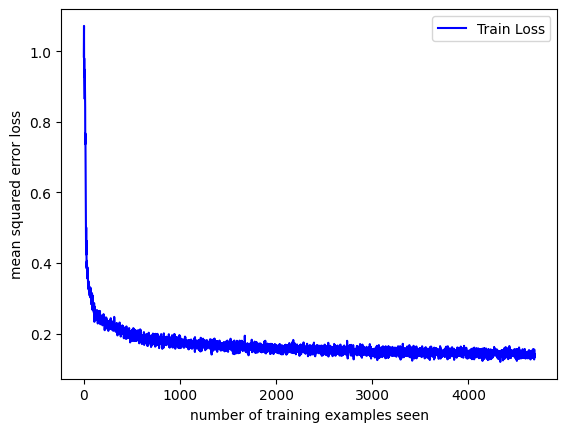

In [83]:
# Loss Visualization
fig = plt.figure()
plt.plot(history["loss"], color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('mean squared error loss')

### Check denoising performance

We see that the training loss decreased, but let's apply the model to the test set to see how well it was able to recover the digits from the noisy images.

In [84]:
def apply_denoising(image, model):
    # add batch and channel dimensions
    image = torch.unsqueeze(torch.unsqueeze(image, 0), 0)
    prediction = model(image.cuda())
    # remove batch and channel dimensions before returning
    return prediction.detach().cpu()[0,0]


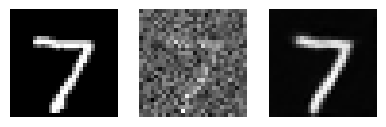

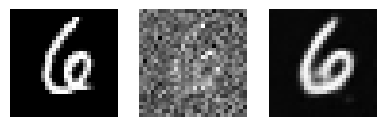

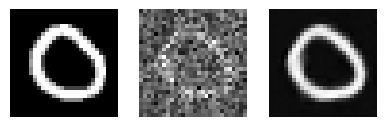

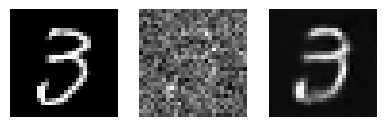

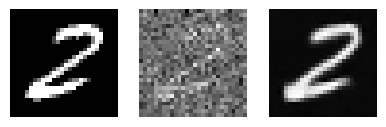

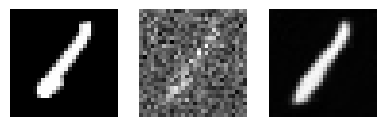

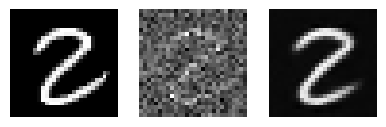

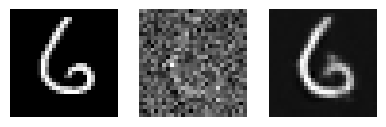

In [85]:
# Displays: ground truth, noisy, and denoised images
def visualize_denoising(model, dataset, index):
    orig_image = dataset[index][0][0]
    noisy_image = add_noise(orig_image)
    denoised_image = apply_denoising(noisy_image, model)
    plt.subplot(1,4,1)
    plt.axis('off')
    plt.imshow(orig_image, cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,2)
    plt.axis('off')
    plt.imshow(noisy_image, cmap=plt.get_cmap('gray'))
    plt.subplot(1,4,3)
    plt.axis('off')
    plt.imshow(denoised_image, cmap=plt.get_cmap('gray'))
    
    plt.show()

# We pick 8 images to show:
for i in range(8):
    visualize_denoising(unet_model, test_dataset, 123*i)
    

<div class="alert alert-info"><h4>
    Task 5.1: </h4>
Did the denoising net trained on MNIST work well on unseen test data? What do you think will happen when we apply it to the Fashion-MNIST data?
</div>

**5.1 Answer:**

The denoising MNIST did relatively well considering it extracted images which allows a human to identify a digit when it wasn't necessarily obvious from the noisy image. It has however been trained to look for digits. Applying it to Fashion-MNIST will possibly sucessfully "remove noise", but recovering objects that it hasn't seen before may not work as well.

**5.1 Answer from 2023 Students:**

It does decently well, not perfect cause it's lots of noise

### Apply trained model on 'wrong' data 

Apply the denoising model trained above to some example _noisy_ images derived from the Fashion-MNIST dataset.


### Load the Fashion MNIST dataset

Similar to the regular MNIST, we will use the pytorch FashionMNIST dataset. This was downloaded in the setup.sh script, so here we are just loading it into memory.

In [86]:
fm_train_dataset = torchvision.datasets.FashionMNIST('./fashion_mnist', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

fm_test_dataset = torchvision.datasets.FashionMNIST('./fashion_mnist', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

Next we apply the denoising model we trained on the MNIST data to FashionMNIST, and visualize the results.


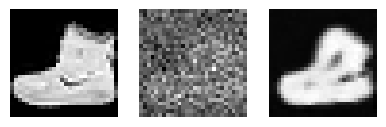

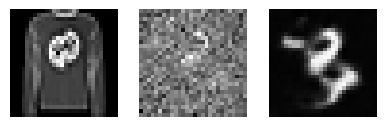

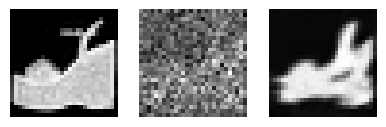

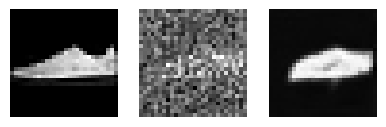

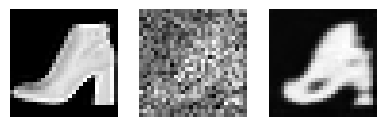

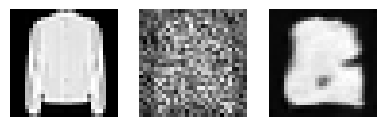

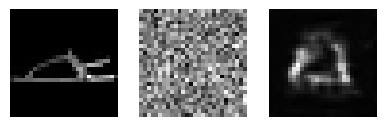

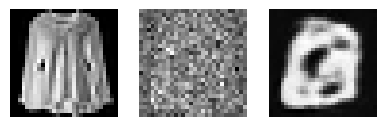

In [87]:
for i in range(8):
    visualize_denoising(unet_model, fm_train_dataset, 123*i)

<div class="alert alert-info"><h4>
    Task 5.2: </h4>
What happened when the MNIST denoising model was applied to the FashionMNIST data? Why do you think the results look as they do?
</div>

**5.2 Answer:**

The "noise" is apparently gone, however, the objects are hardly recognizable. Some look like they have been reshaped like digits in the process.

**5.2 Answer from 2023 Students:**

BAD! Some of them kind of look like numbers. 

<div class="alert alert-info"><h4>
    Task 5.3: </h4>
Can you imagine any real-world scenarios where a denoising model would change the content of an image?
</div>

**5.3 Answer:**

If a denoising model is trained on data which does not appear in the data it is ultimatly used on, that new content will end up likely changed. A real worl example could be that of training a model on lots of non-dividing cells images, and use the model on new data which happens to contain some dividing cells. This could lead to the information being "denoised" away.

**5.3 Answer from 2023**

- Run on any out of distribution data
- Especially tricky if the data appears to be in distribution but has rare events. E.g. if the denoiser was trained on lots of cells that were never dividing and then was run on similar image with dividing cells, it might remove the dividing cell and replace with a single cell.

<div class="alert alert-block alert-success"><h3>
    Checkpoint 5</h3>
    <ol>
        Congrats on reaching the final checkpoint! Let us know on Element, and we'll discuss the questions once reaching critical mass.
    </ol>
</div>

<div class="alert alert-block alert-warning"><h3>
    Bonus Questions</h3>
    <ol>
        <li>Try training a FashionMNIST denoising network and applying it to MNIST. Or, try training a denoising network on both datasets and see how it works on each.</li>
        <li>Go back to Part 4 and try another attribution method, such as <a href="https://captum.ai/api/saliency.html">Saliency</a>, and see how the results differ.</li>
    </ol>
</div>

**Bonus question: Would it work to train first on MNIST and then on Fashion-MNIST?**
To train a network that can do both, training on both datasets would be a good approach. Need to shuffle training examples.
Training on one first and on the other afterwards will likely only work for the second dataset.